In [44]:
include("Optimization/FairClassification.jl")
include("Optimization/FairRegression.jl")
include("Metrics/ClassificationMetrics.jl")
include("Metrics/RegressionMetrics.jl")
include("Utils/DataGeneration.jl");

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [2]:
using PyPlot, MLDataUtils, Statistics, CSV, DataFrames

# Classification Example: Synthetic Data

In [7]:
# Generate classification data
n = 100
d = 2
p = 2
X, y, group_assignments = generate_random_classification_data(n, d, p, σ=2);

In [8]:
w, b = svm_classifier(X, y)
w_fair_convex, b_fair_convex = fair_convex_svm_classifier(X, y, group_assignments)
w_fair, b_fair = fair_svm_classifier(X, y, group_assignments, use_warm_start=true);

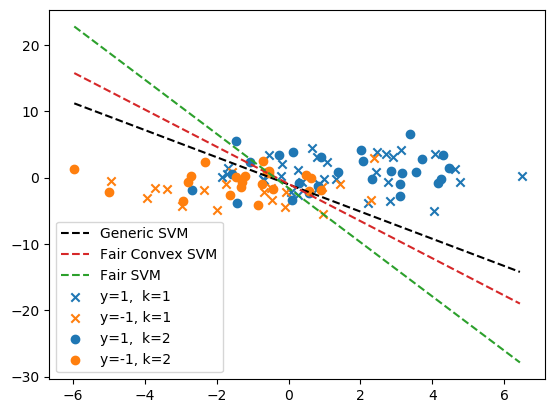

In [9]:
markers = ["x", "o"]
colors = ["tab:blue", "tab:orange"]
for k=1:p
    mask_positive = (y .== 1) .& (group_assignments .== k)
    mask_negative = (y .== -1) .& (group_assignments .== k)
    plt.scatter(X[mask_positive, 1], X[mask_positive, 2], 
        label=string("y=1,  ", "k=", k), marker=markers[k], color=colors[1])
    plt.scatter(X[mask_negative, 1], X[mask_negative, 2], 
        label=string("y=-1, ", "k=", k), marker=markers[k], color=colors[2])
end

X1_grid = minimum(X[:,1]):0.1:maximum(X[:,1])
X2_grid = minimum(X[:,2]):0.1:maximum(X[:,2])
plt.plot(X1_grid, (b .- w[1].*X1_grid)/w[2], 
    color="k", linestyle="--", label="Generic SVM")
plt.plot(X1_grid, (b_fair_convex .- w_fair_convex[1].*X1_grid)/w_fair_convex[2], 
    color="tab:red", linestyle="--", label="Fair Convex SVM")
plt.plot(X1_grid, (b_fair .- w_fair[1].*X1_grid)/w_fair[2], 
    color="tab:green", linestyle="--", label="Fair SVM")
plt.legend();

In [24]:
svm_fairness_summary(X, y, group_assignments, w, b, logger=true);

False positive rate discrepency: 0.153
False negative rate discrepency: 0.034
False discovery rate discrepency: 0.129
False omission rate discrepency: 0.055
Positive rate discrepency: 0.044


In [26]:
svm_performance_summary(X, y, group_assignments, w, b, logger=true);

Accuracy: 0.76
AUC: 0.875


In [25]:
svm_fairness_summary(X, y, group_assignments, w_fair_convex, b_fair_convex, logger=true);

False positive rate discrepency: 0.153
False negative rate discrepency: 0.071
False discovery rate discrepency: 0.12
False omission rate discrepency: 0.096
Positive rate discrepency: 0.064


In [ ]:
svm_performance_summary(X, y, group_assignments, w_fair_convex, b_fair_convex, logger=true);

In [ ]:
svm_fairness_summary(X, y, group_assignments, w_fair, b_fair, logger=true);

In [27]:
svm_performance_summary(X, y, group_assignments, w_fair, b_fair, logger=true);

False positive rate discrepency: 0.055
False negative rate discrepency: 0.034
False discovery rate discrepency: 0.075
False omission rate discrepency: 0.083
Positive rate discrepency: 0.004


# Regression Example: Synthetic Data

In [13]:
# Generate regression data
n = 100
d = 1
p = 2
X, y, group_assignments = generate_random_regression_data(100, 1, 2);

([0.3069546436764865; 0.054308783625442114; … ; 1.1113940925763952; 0.9907120274373051], [-0.11061123833421743, -0.05353983262453809, 0.14549110035119117, -0.27108252915125775, -0.055012154077589755, -0.18352102392450437, 0.02442061354363055, -0.18311709359533804, -0.04205780121864837, 0.15985095155996337  …  -0.17237118935361395, -0.1654827761781798, -0.29454235418053654, -0.28134523914969006, -0.19414320021085496, 0.024449839439983245, -0.03372621584115984, -0.17368391128916966, -0.2030993998520305, -0.30862843489910835], [2, 2, 1, 2, 1, 2, 2, 1, 2, 1  …  1, 2, 2, 2, 2, 1, 1, 2, 2, 1])

In [14]:
# Fit models
β = lasso_regressor(X, y)
β_fair = fair_lasso_regressor(X, y, group_assignments);

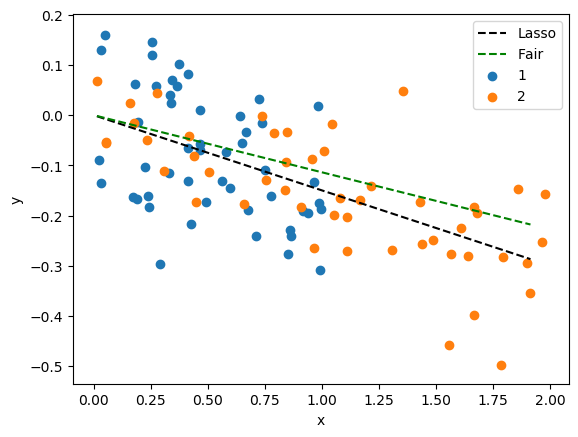

In [15]:
# Visualize models
for k=1:p
    plt.scatter(X[group_assignments .== k], y[group_assignments .== k], label=k)
end
X_grid = minimum(X):0.1:maximum(X)
plt.plot(X_grid, β.*X_grid, color="k", linestyle="--", label="Lasso")
plt.plot(X_grid, β_fair.*X_grid, color="g", linestyle="--", label="Fair")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

In [16]:
regressor_fairness_summary(X, y, group_assignments, β, logger=true);

Mean undershoot discrepency: 0.012
Mean overshoot discrepency: 0.015
Mean value discrepency: 0.083


In [17]:
regressor_fairness_summary(X, y, group_assignments, β_fair, logger=true);

Mean undershoot discrepency: 0.019
Mean overshoot discrepency: 0.003
Mean value discrepency: 0.063


In [33]:
regressor_performance_summary(X, y, group_assignments, β, logger=true);

MAE: 0.082
R2: 0.412


In [34]:
regressor_performance_summary(X, y, group_assignments, β_fair, logger=true);

MAE: 0.088
R2: 0.323


# Classification Example: COMPAS Dataset

In [31]:
X,y,groupAssignments = load_classification_data("./Data/fairClassificationData.csv")

#Shuffle the dataset
(Xr, yr, groupAssignmentsr) = shuffleobs((X, y, groupAssignments), obsdim = 1)

#Split the data to train and test/validation
(trainX, trainY, trainG), (otherX, otherY, otherG) = splitobs(((Xr, yr, groupAssignmentsr)); at = 0.5, obsdim = 1)

#Split again to validation and test
(valX, valY, valG), (testX, testY, testG) = splitobs((otherX, otherY, otherG); at = 0.5, obsdim = 1)
trainX = convert(Array{Float64, 2}, trainX)
trainY = convert(Array{Int64,1}, trainY)
trainG = convert(Array{Int64,1}, trainG)
valX = convert(Array{Float64, 2}, valX)
valY = convert(Array{Int64,1}, valY)
valG = convert(Array{Int64,1}, valG)
testX = convert(Array{Float64, 2}, testX)
testY = convert(Array{Int64,1}, testY)
testG = convert(Array{Int64,1}, testG);

┌ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
└ @ IAIBase C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAIBase\ymcNn\src\precompile.jl:19
┌ Warning: Interpretable AI license expires soon: 2019-12-31. If you need to renew, please send us the following machine ID:
│ 3e4e85a5ca058b62ff34f7ca353ddc5d1b5d7d82a8725887be3c9c9f400046ce
└ @ IAIBase C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAIBase\ymcNn\src\precompile.jl:29


In [32]:
aucArray = []
gammaArray = []
wArray = []
bArray = []
for j=-4:4
    for i=1:10
        testΓ = i*10.0^j
        w, b = svm_classifier(trainX, trainY, Γ = testΓ)
        calcauc = calculate_svm_auc(trainX, trainY, w, b)
        push!(aucArray, calcauc)
        push!(gammaArray, testΓ)
    end
end
bestΓ = gammaArray[aucArray .== minimum(aucArray)]
bestΓ = bestΓ[1]
w, b = svm_classifier(trainX, trainY, Γ = bestΓ)
println(bestΓ)
trainValX = vcat(trainX, valX)
trainValY = vcat(trainY, valY)
trainValG = vcat(trainG, valG)
    
w_fair_convex, b_fair_convex = fair_convex_svm_classifier(trainValX, trainValY, trainValG, Γ = bestΓ, η=0.5, solver_time_limit=300)
    
bigM = calculate_big_M(trainValX)    

w_fair, b_fair = fair_svm_classifier(trainValX, trainValY, trainValG, use_warm_start=true, Γ = bestΓ,  M=bigM, δ = 0.05, solver_time_limit= 10000);

0.8


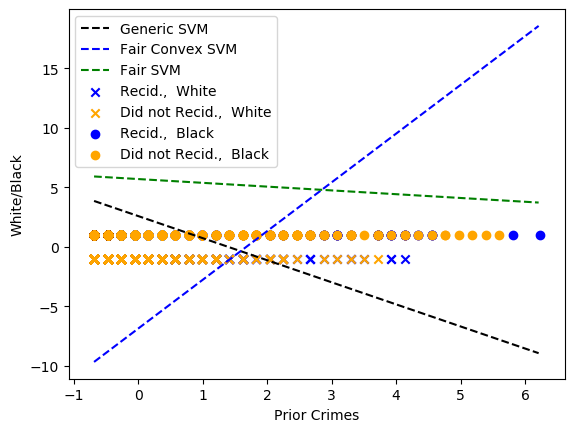

In [33]:
markers = ["x", "o", "v"]
colors = ["blue", "orange", "red"]
p =length(unique(testG))
parameterToPlot1 = 4
parameterToPlot2 = 12
Xplot1 = testX[:,parameterToPlot1]
Xplot2 = testX[:,parameterToPlot2]
labelArray = ["White", "Black"]
for k=1:p
    mask_positive = (testY .== 1) .& (testG .== k)
    mask_negative = (testY .== -1) .& (testG .== k)
    plt.scatter(Xplot1[(testY .== 1) .& (testG .== k)], Xplot2[(testG.==k) .& (testY.==1)], label=string("Recid.,  ", labelArray[k]), marker=markers[k],
        color=colors[1])
    plt.scatter(Xplot1[(testY .== -1) .& (testG .== k)], Xplot2[(testG.==k) .& (testY.==-1)], label=string("Did not Recid.,  ", labelArray[k]), marker=markers[k],
        color=colors[2])
end

X1_grid = minimum(testX[:,parameterToPlot1]):0.1:maximum(testX[:,parameterToPlot1])
plt.plot(X1_grid, (b .- w[parameterToPlot1].*X1_grid)/w[parameterToPlot2], color="k", linestyle="--", label="Generic SVM")
plt.plot(X1_grid, (b_fair_convex .- w_fair_convex[parameterToPlot1].*X1_grid)/w_fair_convex[parameterToPlot2], color="b", linestyle="--", label="Fair Convex SVM")
plt.plot(X1_grid, (b_fair .- w_fair[parameterToPlot1].*X1_grid)/w_fair[parameterToPlot2], color="g", linestyle="--", label="Fair SVM")
plt.xlabel("Prior Crimes")
plt.ylabel("White/Black")
plt.legend();

In [34]:
svm_performance_summary(testX, testY, testG, w, b, logger=true);

Accuracy: 0.693
AUC: 0.671


In [35]:
svm_fairness_summary(testX, testY, testG, w, b, logger = true);

False positive rate discrepency: 0.326
False negative rate discrepency: 0.55
False discovery rate discrepency: 0.099
False omission rate discrepency: 0.019
Positive rate discrepency: 0.417


In [36]:
svm_performance_summary(testX, testY, testG, w_fair_convex, b_fair_convex, logger=true);

Accuracy: 0.704
AUC: 0.679


In [37]:
svm_fairness_summary(testX, testY, testG, w_fair_convex, b_fair_convex, logger = true);

False positive rate discrepency: 0.023
False negative rate discrepency: 0.014
False discovery rate discrepency: 0.04
False omission rate discrepency: 0.09
Positive rate discrepency: 0.035


In [38]:
svm_performance_summary(testX, testY, testG, w_fair, b_fair,logger=true);

Accuracy: 0.677
AUC: 0.635


In [45]:
svm_fairness_summary(testX, testY, testG, w_fair, b_fair, logger = true);

False positive rate discrepency: 0.0
False negative rate discrepency: 0.002
False discovery rate discrepency: 0.0
False omission rate discrepency: 0.095
Positive rate discrepency: 0.001


# Regression Example: Cities and Crimes Dataset

In [21]:
X, y, groupAssignments = load_regression_data("./Data/fairRegressionData.csv")
#Shuffle the dataset
(Xr, yr, groupAssignmentsr) = shuffleobs((X, y, groupAssignments), obsdim = 1)

#Split the data to train and test/validation
(trainX, trainY, trainG), (otherX, otherY, otherG) = splitobs(((Xr, yr, groupAssignmentsr)); at = 0.5, obsdim = 1)

#Split again to validation and test
(valX, valY, valG), (testX, testY, testG) = splitobs((otherX, otherY, otherG); at = 0.5, obsdim = 1)
trainX = convert(Array{Float64, 2}, trainX)
trainY = convert(Array{Float64,1}, trainY)
trainG = convert(Array{Int64,1}, trainG)
valX = convert(Array{Float64, 2}, valX)
valY = convert(Array{Float64,1}, valY)
valG = convert(Array{Int64,1}, valG)
testX = convert(Array{Float64, 2}, testX)
testY = convert(Array{Float64,1}, testY)
testG = convert(Array{Int64,1}, testG);

In [26]:
testΓ=0
gammaArray = []
maeArray =  []
β = 0
for j= -4:4
    for i=1:10
        testΓ = i*10.0^j
        β = lasso_regressor(trainX, trainY, Γ = testΓ)
        yhat = valX*β
        MAE = calculate_MAE(valY, yhat)
        push!(gammaArray, testΓ)
        push!(maeArray, MAE)
    end
end

bestΓ = gammaArray[maeArray .== minimum(maeArray)]
bestΓ = bestΓ[1]
println(bestΓ)

trainValX = vcat(trainX, valX)
trainValY = vcat(trainY, valY)
trainValG = vcat(trainG, valG)
β = lasso_regressor(trainValX, trainValY, Γ = bestΓ)
yhat = trainValX *β
MAE = calculate_MAE(trainValY, yhat)
calcλ = MAE/(sum((abs(yhat[i])) for i in 1:length(yhat))./length(yhat))
println(calcλ)
β_fair = fair_lasso_regressor(trainValX, trainValY, trainValG, θ = 0.5, λ=calcλ, Γ=bestΓ)

0.002
0.4042812016697134


11-element Array{Float64,1}:
  0.3104544480993346   
 -0.002799582987178449 
  0.06889774390905347  
 -3.270654676452025e-7 
  0.08603724076587002  
  0.06177446935740336  
 -1.5210969623283738e-6
  0.08856755130225646  
  0.15772383736777001  
  0.08021190876054353  
  0.1539122164413904   

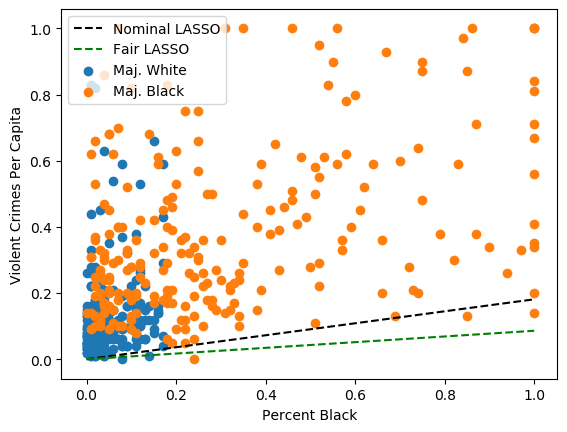

In [27]:
p = 2
parameterToPlot = 5
Xplot = testX[:,parameterToPlot]
labelArray = ["Maj. White", "Maj. Black"]
for k=1:p
    plt.scatter(Xplot[testG .== k], testY[testG .== k], label=labelArray[k])
end
#print(β[5])

X_grid = minimum(Xplot):0.1:maximum(Xplot)
plt.plot(X_grid, β[parameterToPlot].*X_grid, color="k", linestyle="--", label="Nominal LASSO")
plt.plot(X_grid, β_fair[parameterToPlot].*X_grid, color="g", linestyle="--", label="Fair LASSO")
plt.xlabel("Percent Black")
plt.ylabel("Violent Crimes Per Capita")
plt.legend();

In [28]:
regressor_fairness_summary(trainValX, trainValY, trainValG, β, logger=true);
regressor_performance_summary(trainValX, trainValY, trainValG, β, logger=true);

Mean undershoot discrepency: 0.041
Mean overshoot discrepency: 0.027
Mean value discrepency: 0.253
MAE: 0.096
R2: 0.661


In [30]:
regressor_fairness_summary(trainValX, trainValY, trainValG, β_fair, logger=true);
regressor_performance_summary(trainValX, trainValY, trainValG, β_fair, logger=true);

Mean undershoot discrepency: 0.071
Mean overshoot discrepency: 0.011
Mean value discrepency: 0.184
MAE: 0.106
R2: 0.612
